In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [32]:
# Reading in earlier produced fits
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/mstars')
fgkm_fit = from_csv(path=fit_save_location)

01:33:59 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.
	Chain 1 had 3 divergent transitions (0.3%)
	Chain 2 had 5 divergent transitions (0.5%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 13 divergent transitions (1.3%)
	Use function "diagnose()" to see further information.


In [20]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

Number of stars in selected sample: 23789


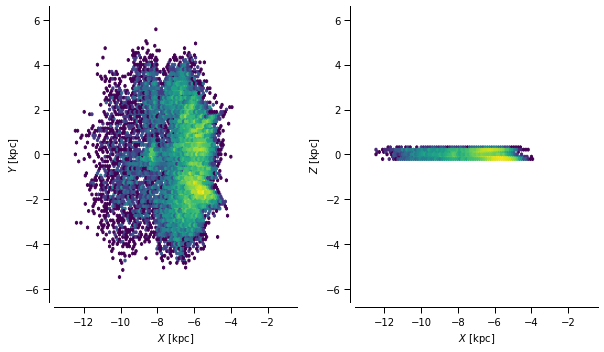

In [21]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars
spt_lum_filter = mstars
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/mstars')

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


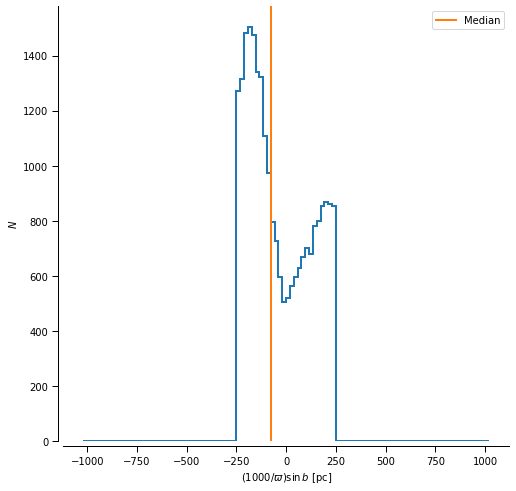

In [22]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [23]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")
fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }

base_bp_model = {'stanfile':'rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }
stan_model = base_bp_model

Number of sources in sample: 3000


In [33]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+3]

DEBUG:cmdstanpy:cmd: C:\Users\rjrri\anaconda3\Library\bin\cmdstan\bin\stansummary.exe --percentiles= 5,50,95 --sig_figs=6 --csv_filename=C:\Users\rjrri\AppData\Local\Temp\tmpu3f1atq3\stansummary-rotcurve_bp2_1_model-37sfjzuf.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230227012052_1.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230227012052_2.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230227012052_3.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230227012052_4.csv
cwd: None


C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-23358.100000,0.046335,1.910960,-23361.700000,-23357.800000,-23355.600000,1700.92,1.41136,1.000730
h_param,0.109333,0.001445,0.100639,0.007315,0.079802,0.310814,4847.61,4.02238,0.999501
p_param,-0.564717,0.005939,0.329792,-1.146050,-0.547580,-0.048939,3083.51,2.55859,1.000380
Vsun_pec_x,9.663150,0.013043,0.854145,8.254980,9.679260,11.054100,4288.34,3.55831,1.000140
Vsun_pec_y,-213.621000,0.016351,0.960909,-215.177000,-213.631000,-212.102000,3453.49,2.86558,1.000680
Vsun_pec_z,8.180650,0.008646,0.560158,7.257320,8.182670,9.100540,4197.23,3.48271,0.999649
vdispxy,39.587200,0.007679,0.468781,38.814500,39.583900,40.355500,3727.10,3.09261,0.999899
vdispz,23.356900,0.006747,0.464135,22.603600,23.353200,24.136100,4731.69,3.92619,0.999654
"model_pm[1,1]",14.751600,0.012670,0.913541,13.203500,14.762900,16.226800,5198.40,4.31345,0.999635
"model_pm[1,2]",-10.966100,0.009828,0.623896,-12.010000,-10.967300,-9.937920,4029.65,3.34366,1.000140


In [34]:
import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [31]:
# data Rsun
# real Vcirc_sun = Rsun/h_param * (1 + (Rsun/h_param)^2) ^ ((p_param-2)/4);
# This is only the scaling factor. What is v_0?
Rsun_float = float(Rsun/(1*u.pc)) # in pc
print(Rsun_float)
h_param = 0.14
p_param = 0.370 # in pc
# v_0 = 
vcsun_data = 234.0
Vcircsun = Rsun_float/h_param * (1 + (Rsun_float/h_param)**2) ** ((p_param-2)/4)
v0 = vcsun_data/Vcircsun
vc = v0*Vcircsun

print("Vcircsun:", Vcircsun*u.pc/(u.s))
Vcircsun_with_units = Vcircsun*u.pc/u.s
print("Vcircsun:", Vcircsun_with_units.to(u.km/u.s))
print(v0)
print(vc)

8277.0
Vcircsun: 7.6343630711626504 pc / s
Vcircsun: 235571829776521.75 km / s
30.65088702473299
234.0


In [ ]:
fgkm_fit.diagnose()

DEBUG:cmdstanpy:cmd: C:\Users\rjrri\anaconda3\Library\bin\cmdstan\bin\diagnose.exe C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230226224120_1.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230226224120_2.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230226224120_3.csv C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles/mstars\rotcurve-bp2_1-20230226224120_4.csv
cwd: None


['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz']
h_param = 0.1+0.1-0.1
p_param = 0.4+0.1-0.1
Vsun_pec_x = 19.3+2.6-2.4
Vsun_pec_y = -136.6+2.7-2.9
Vsun_pec_z = 8.9+0.4-0.4
vdispxy = 98.0+1.3-1.2
vdispz = 20.3+0.3-0.3


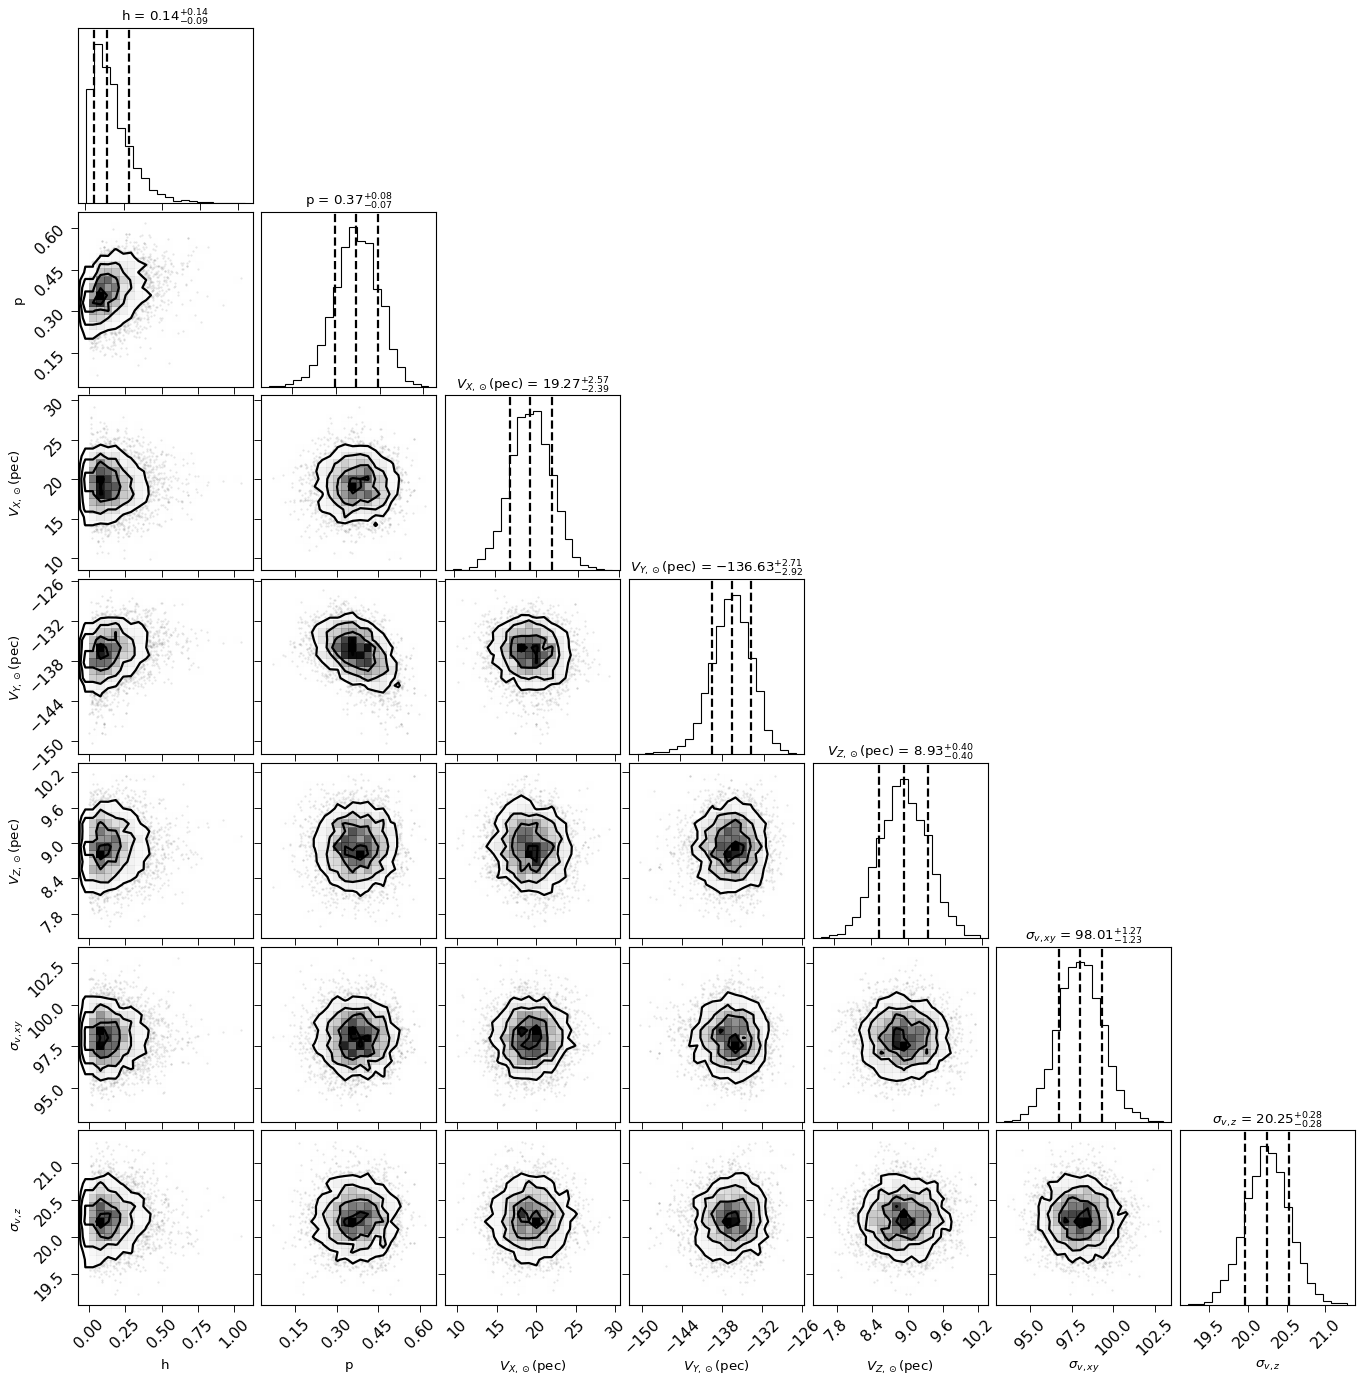

{'h_param': 0.143819, 'p_param': 0.37039500000000003, 'Vsun_pec_x': 19.27055, 'Vsun_pec_y': -136.62849999999997, 'Vsun_pec_z': 8.92943, 'vdispxy': 98.00795, 'vdispz': 20.25045}
7
[array([0.177278 , 0.242063 , 0.191967 , ..., 0.276071 , 0.0928625,
       0.142881 ]), array([0.463119, 0.323939, 0.318051, ..., 0.303394, 0.362961, 0.359201]), array([13.5563, 15.3212, 18.513 , ..., 21.5488, 20.0819, 19.7877]), array([-140.489, -135.54 , -135.661, ..., -132.527, -137.914, -135.226]), array([9.25201, 9.33259, 8.51907, ..., 8.82868, 8.74447, 8.68355]), array([96.9301, 98.0456, 98.4216, ..., 96.8554, 99.5475, 99.0335]), array([19.6936, 19.9267, 20.0467, ..., 20.5341, 20.4225, 20.5211])]
[[1.77278e-01 4.63119e-01 1.35563e+01 ... 9.25201e+00 9.69301e+01
  1.96936e+01]
 [2.42063e-01 3.23939e-01 1.53212e+01 ... 9.33259e+00 9.80456e+01
  1.99267e+01]
 [1.91967e-01 3.18051e-01 1.85130e+01 ... 8.51907e+00 9.84216e+01
  2.00467e+01]
 ...
 [2.76071e-01 3.03394e-01 2.15488e+01 ... 8.82868e+00 9.68554e+01

In [29]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

# Number of draws is very low
print(stan_model['best_params'])
print(len(sample_lists))
print(sample_lists)
print(samples)
print(len(samples)) # 4000 samples
# Dit was gecreerd met een subsample van 10000 ipv 3000.